In [8]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
'''
Built on top of NetworkX and GeoPandas, and interacts with OpenStreetMap APIs, to:

- Download and model street networks or other infrastructure anywhere in the world with a single line of code
- Download geospatial features (e.g., political boundaries, building footprints, grocery stores, transit stops) as a GeoDataFrame
- Query by city name, polygon, bounding box, or point/address + distance
- Model driving, walking, biking, and other travel modes
- Attach node elevations from a local raster file or web service and calculate edge grades
- Impute missing speeds and calculate graph edge travel times
- Simplify and correct the networks topology to clean-up nodes and consolidate complex intersections
- Fast map-matching of points, routes, or trajectories to nearest graph edges or nodes
- Save/load network to/from disk as GraphML, GeoPackage, or OSM XML file
- Conduct topological and spatial analyses to automatically calculate dozens of indicators
- Calculate and visualize street bearings and orientations
- Calculate and visualize shortest-path routes that minimize distance, travel time, elevation, etc
- Explore street networks and geospatial features as a static map or interactive web map
- Visualize travel distance and travel time with isoline and isochrone maps
- Plot figure-ground diagrams of street networks and building footprints

'''

# houston texas

'\nBuilt on top of NetworkX and GeoPandas, and interacts with OpenStreetMap APIs, to:\n\n- Download and model street networks or other infrastructure anywhere in the world with a single line of code\n- Download geospatial features (e.g., political boundaries, building footprints, grocery stores, transit stops) as a GeoDataFrame\n- Query by city name, polygon, bounding box, or point/address + distance\n- Model driving, walking, biking, and other travel modes\n- Attach node elevations from a local raster file or web service and calculate edge grades\n- Impute missing speeds and calculate graph edge travel times\n- Simplify and correct the networks topology to clean-up nodes and consolidate complex intersections\n- Fast map-matching of points, routes, or trajectories to nearest graph edges or nodes\n- Save/load network to/from disk as GraphML, GeoPackage, or OSM XML file\n- Conduct topological and spatial analyses to automatically calculate dozens of indicators\n- Calculate and visualize 

In [9]:
# load in the plot
G = ox.graph_from_place("Houston, Texas, USA", network_type="drive")

In [3]:
G.edges, G.nodes

(OutMultiEdgeView([(151365298, 151365299, 0), (151365298, 152572572, 0), (151365298, 152572569, 0), (151365299, 151365298, 0), (151365299, 152810114, 0), (151365299, 152572569, 0), (151365329, 151365331, 0), (151365329, 152242296, 0), (151365329, 152187969, 0), (151365331, 153262427, 0), (151365331, 152960293, 0), (151365331, 151365329, 0), (151365339, 151365341, 0), (151365339, 598213120, 0), (151365339, 152638115, 0), (151365341, 151365339, 0), (151365341, 152638115, 0), (151365341, 153030182, 0), (151365886, 2868778330, 0), (151365886, 2868778326, 0), (151366108, 151366109, 0), (151366108, 152324016, 0), (151366108, 7138686737, 0), (151366109, 151366108, 0), (151366109, 152457413, 0), (151366109, 152324019, 0), (151366109, 151366111, 0), (151366111, 152324023, 0), (151366111, 151366109, 0), (151366111, 152319300, 0), (151366417, 151366418, 0), (151366417, 152323560, 0), (151366417, 151489316, 0), (151366418, 151366419, 0), (151366418, 151366417, 0), (151366418, 151489316, 0), (15136

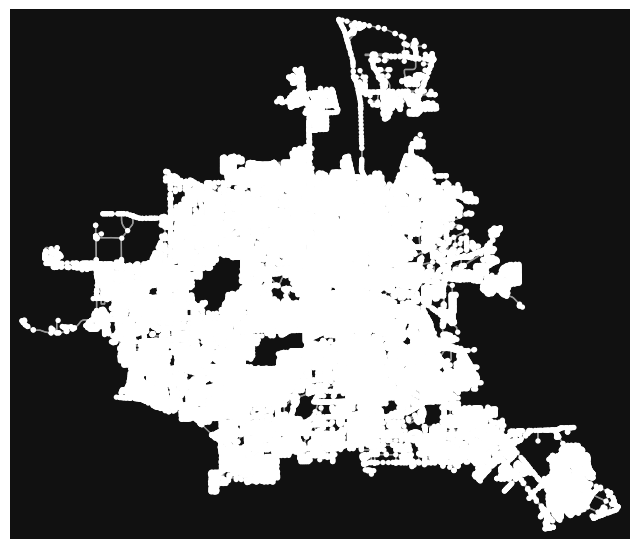

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G)

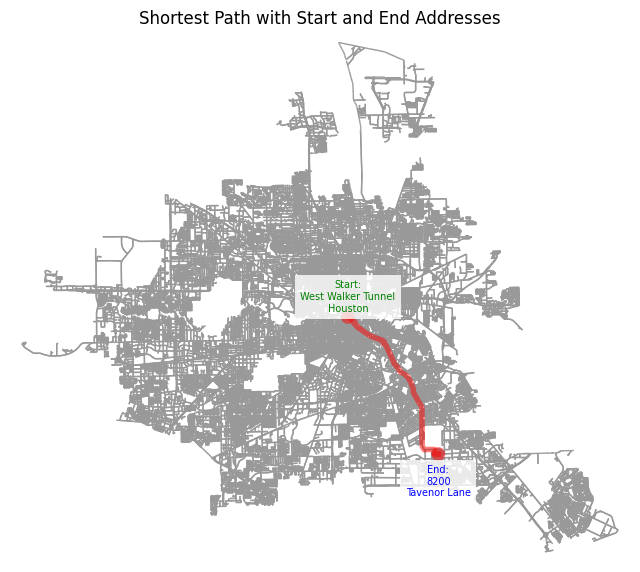

In [43]:
# Define start and end coordinates
start_point = (29.7604, -95.3698)  # Downtown Houston
end_point = (29.6297, -95.2735)    # A distant point in Houston

# Find the nearest nodes to the coordinates
start_node = ox.distance.nearest_nodes(G, X=start_point[1], Y=start_point[0])
end_node = ox.distance.nearest_nodes(G, X=end_point[1], Y=end_point[0])

# Compute the shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight="length")

# Use reverse geocoding to find addresses for the start and end points
geolocator = Nominatim(user_agent="route-annotator")
start_address_full = geolocator.reverse(start_point, language="en").address
end_address_full = geolocator.reverse(end_point, language="en").address

# Extract a shorter version of the address (e.g., street and city only)
def shorten_address(full_address):
    parts = full_address.split(", ")
    if len(parts) > 2:
        return f"{parts[0]}\n{parts[1]}"
    return full_address

start_address = shorten_address(start_address_full)
end_address = shorten_address(end_address_full)

# Plot the graph and the shortest path
fig, ax = ox.plot_graph_route(
    G,
    shortest_path,
    route_linewidth=4,
    node_size=0,
    bgcolor="white",
    route_color="red",
    show=False,
    close=False
)

# Add addresses as text with manual offsets
start_x, start_y = G.nodes[start_node]['x'], G.nodes[start_node]['y']
end_x, end_y = G.nodes[end_node]['x'], G.nodes[end_node]['y']

# Add text below the start node (offset downward)
ax.text(
    start_x, start_y + 0.005, f"Start:\n{start_address}",  # Offset downward
    fontsize=7, color="green", ha="center",
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

# Add text above the end node (offset upward)
ax.text(
    end_x, end_y - 0.04, f"End:\n{end_address}",  # Offset upward
    fontsize=7, color="blue", ha="center",
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

plt.title("Shortest Path with Start and End Addresses")
plt.show()

In [5]:
# convert your MultiDiGraph to an undirected MultiGraph
#M = ox.convert.to_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.convert.to_digraph(G)

# not necessary in our case

In [6]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [7]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                      
residential     123.1       25.1         17.7
secondary       112.0       44.3          9.2
tertiary        103.5       40.2          9.3
tertiary_link    56.3       36.5          5.6
unclassified     28.7       36.5          2.8

In [8]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

/var/folders/02/895d_ly16w54v11n_x2ttx2h0000gn/T/ipykernel_11746/4260142167.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graph_area_m = nodes_proj.unary_union.convex_hull.area


4199465.640327393

In [9]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 352,
 'm': 944,
 'k_avg': 5.363636363636363,
 'edge_length_total': 112049.277,
 'edge_length_avg': 118.69626800847458,
 'streets_per_node_avg': np.float64(2.9488636363636362),
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 270, 4: 46, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09659090909090909,
  2: 0.0,
  3: 0.7670454545454546,
  4: 0.13068181818181818,
  5: 0.005681818181818182},
 'intersection_count': np.int64(318),
 'street_length_total': 58086.481,
 'street_segment_count': 495,
 'street_length_avg': 117.34642626262627,
 'circuity_avg': np.float64(1.1112710818481102),
 'self_loop_proportion': 0.006060606060606061,
 'clean_intersection_count': 267,
 'node_density_km': 83.82018812578208,
 'intersection_density_km': np.float64(75.72391995454177),
 'edge_density_km': 26681.7939701644,
 'street_density_km': 13831.874332342803,
 'clean_intersection_density_km': 63.5795176976813}

In [10]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

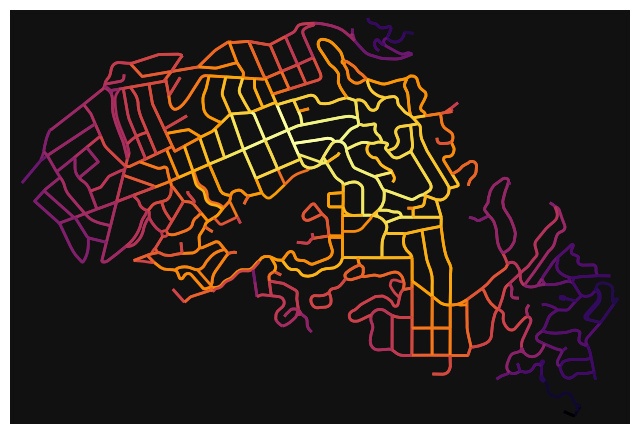

In [11]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

In [12]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [16]:
# print the travel speed for all edges and nodes
nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))
for u, v, data in G.edges(data=True):
    travel_speed = data.get('speed_kph', 'Unknown')  # Replace 'speed_kph' with the actual key if different
    print(f"Edge from {u} to {v} has travel speed: {travel_speed} km/h")

Edge from 53017091 to 53064327 has travel speed: 25.1 km/h
Edge from 53017091 to 53075599 has travel speed: 25.1 km/h
Edge from 53018397 to 53018399 has travel speed: 25.1 km/h
Edge from 53018397 to 53018411 has travel speed: 40.2 km/h
Edge from 53018397 to 53097980 has travel speed: 40.2 km/h
Edge from 53018399 to 53018402 has travel speed: 25.1 km/h
Edge from 53018399 to 53018397 has travel speed: 25.1 km/h
Edge from 53018399 to 53078914 has travel speed: 25.1 km/h
Edge from 53018402 to 53018399 has travel speed: 25.1 km/h
Edge from 53018402 to 53018404 has travel speed: 25.1 km/h
Edge from 53018402 to 53078914 has travel speed: 25.1 km/h
Edge from 53018404 to 53064328 has travel speed: 25.1 km/h
Edge from 53018404 to 53018402 has travel speed: 25.1 km/h
Edge from 53018404 to 53114726 has travel speed: 25.1 km/h
Edge from 53018410 to 53018411 has travel speed: 25.1 km/h
Edge from 53018410 to 53057697 has travel speed: 25.1 km/h
Edge from 53018410 to 53062956 has travel speed: 25.1 km